<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/Label_Smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai.vision import *
from torchvision.models import *
from utils import *
import pandas as pd
from pathlib import Path

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')

In [ ]:
cp /content/Drive/My\ Drive/CheXpert-v1.0-small.zip .

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

In [ ]:
full_train_df = pd.read_csv('./CheXpert-v1.0-small/train.csv')
full_train_df = add_columns(full_train_df, False)

In [ ]:
full_valid_df = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
full_valid_df = add_columns(full_valid_df, True)

In [ ]:
def atel(row):
  if row['Atelectasis'] == 1:
    return 1
  elif row['Atelectasis'] == -1:
    return 0.8
  else:
    return 0

In [ ]:
def edema(row):
  if row['Edema'] == 1:
    return 1
  elif row['Edema'] == -1:
    return 0.8
  else:
    return 0

In [ ]:
def pleu(row):
  if row['Pleural Effusion'] == 1:
    return 1
  elif row['Pleural Effusion'] == -1:
    return 0.2
  else:
    return 0

In [ ]:
def conso(row):
  if row['Consolidation'] == 1:
    return 1
  elif row['Consolidation'] == -1:
    return 0.2
  else:
    return 0

In [ ]:
def card(row):
  if row['Cardiomegaly'] == 1:
    return 1
  elif row['Cardiomegaly'] == -1:
    return 0.2
  else:
    return 0

In [ ]:
full_train_df['T Atelectasis'] = full_train_df.apply(atel, axis=1)
full_train_df['T Edema'] = full_train_df.apply(edema, axis=1)
full_train_df['T Pleural Effusion'] = full_train_df.apply(pleu, axis=1)
full_train_df['T Consolidation'] = full_train_df.apply(conso, axis=1)
full_train_df['T Cardiomegaly'] = full_train_df.apply(card, axis=1)

In [ ]:
full_valid_df['T Atelectasis'] = full_valid_df.apply(atel, axis=1)
full_valid_df['T Edema'] = full_valid_df.apply(edema, axis=1)
full_valid_df['T Pleural Effusion'] = full_valid_df.apply(pleu, axis=1)
full_valid_df['T Consolidation'] = full_valid_df.apply(conso, axis=1)
full_valid_df['T Cardiomegaly'] = full_valid_df.apply(card, axis=1)

In [ ]:
full_df = pd.concat([full_train_df, full_valid_df])

In [24]:
full_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,T Atelectasis,T Edema,T Pleural Effusion,T Consolidation,T Cardiomegaly
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2,0.8,0.8,0.2,0.2,0.2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,0.0,0.0,0.0,0.2,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,0.0,0.0,0.0,0.2,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,CheXpert-v1.0-small/valid/patient64736/study1/...,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64736,study1,0.0,0.0,0.0,0.0,0.0
230,CheXpert-v1.0-small/valid/patient64737/study1/...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64737,study1,0.0,0.0,0.0,0.0,0.0
231,CheXpert-v1.0-small/valid/patient64738/study1/...,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64738,study1,0.0,1.0,0.0,0.0,1.0
232,CheXpert-v1.0-small/valid/patient64739/study1/...,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,patient64739,study1,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfms = get_transforms(do_flip=False, max_zoom=1.0, max_lighting=0.1)

In [ ]:
src = ImageList.from_df(full_df, '.', 'Path').split_from_df('train_valid').label_from_df(cols=['T Atelectasis','T Edema','T Pleural Effusion','T Consolidation', 'T Cardiomegaly'], label_cls=MultiCategoryList, one_hot=True, classes=['Atelectasis','Edema','Pleural Effusion','Consolidation', 'Cardiomegaly'])

In [ ]:
data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=56).normalize(imagenet_stats)

In [28]:
learn = cnn_learner(data, models.densenet121, pretrained=True, metrics=avg_auc_metric)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.20E-02


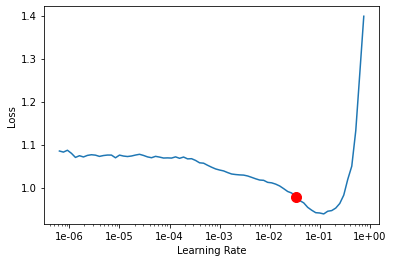

In [29]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 3e-2

In [ ]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='avg_auc_metric', name='mixed_lsr')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.418178,0.461810,0.864201,59:24
1,0.433248,0.467506,0.876642,58:33
2,0.426656,0.468040,0.839002,59:04
3,0.419994,0.519143,0.883726,57:54


Buffered data was truncated after reaching the output size limit.

In [ ]:
import shutil
shutil.make_archive('models', 'zip', 'models')
from google.colab import files
files.download('models.zip') 

In [ ]:
learn.load('mixed_lsr_1')

In [20]:
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.828	 chexpert auc: 0.858	 difference:    0.0297
Cardiomegaly    	 auc: 0.844	 chexpert auc: 0.854	 difference:    0.00992
Consolidation   	 auc: 0.874	 chexpert auc: 0.939	 difference:    0.0653
Edema           	 auc: 0.92	 chexpert auc: 0.941	 difference:    0.021
Pleural Effusion	 auc: 0.925	 chexpert auc: 0.936	 difference:    0.0115

Average auc: 0.878 	 CheXpert average auc 0.906	 Difference 0.0275
